In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

# from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter

2023-08-11 16:10:54.579315: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 16:10:54.649233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 16:11:16.067232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.MultiWorkerMirroredStrategy()

2023-08-11 16:12:07.976312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6838 MB memory:  -> device: 0, name: Tesla P4, pci bus id: 0000:1d:00.0, compute capability: 6.1
2023-08-11 16:12:07.977932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6838 MB memory:  -> device: 1, name: Tesla P4, pci bus id: 0000:1e:00.0, compute capability: 6.1
2023-08-11 16:12:07.979386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 6838 MB memory:  -> device: 2, name: Tesla P4, pci bus id: 0000:3d:00.0, compute capability: 6.1
2023-08-11 16:12:07.980826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 6838 MB memory:  -> device: 3, name: Tesla P4, pci bus id: 0000:3e:00.0, compute capability: 6.1


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3'), communication = CommunicationImplementation.AUTO


In [4]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [5]:
RESULTS_FOLDER = 'results_1_with400'

In [6]:
### Configuration
os.mkdir(RESULTS_FOLDER) if not os.path.isdir(RESULTS_FOLDER) else None
folders = ['all_exp_plots_g', 'all_exp_plots', 'exp_plots', 'model_weights', 'raw_exps', 'training_plots', 'all_val_plots', 'raw_vals',
           'training_plots/train','training_plots/val','training_plots/val_c']
for folder in folders:
    if(not os.path.isdir(f'{RESULTS_FOLDER}/{folder}')):
        os.mkdir(f'{RESULTS_FOLDER}/{folder}')

In [7]:
tf.random.set_seed(seed=20)

In [8]:
### Hyperparameters
# BATCH_SIZE = 128
# EPOCH = 100
# BATCH_SIZE = 32
# EPOCH = 1

In [81]:
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 200

In [82]:
BUFFER_SIZE = 90000

### Load dataset 

In [83]:
### Normalization

In [84]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [85]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [86]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (5.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [87]:
### EoNormalization

In [88]:
def load(image_file, image_size=(128,128)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, image_size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [89]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [90]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [91]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [92]:
def check_count(log_path):
    soft = 0
    hard = 0
    for lp in log_path:
        with open(lp) as f:
            data = f.read()
        data = data.split(' ')
        mod = data[9]
        assert mod == 'mod1'
        mod_value = float(data[10].splitlines()[0])
        if mod_value < 1.0:
            soft = soft + 1
        if mod_value > 1.0:
            hard = hard + 1
    return soft, hard

In [93]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [94]:
# input_path = glob.glob('data/TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('data/TrainData*/*/modulus_128x128*.raw')
# # input_path.sort(key= lambda x: int(x.split('/')[-2]))
# # target_path.sort(key= lambda x: int(x.split('/')[-2]))

In [95]:
input_path = glob.glob('alldata/*TrainData*/*/uY_128x128*.raw')
target_path = glob.glob('alldata/*TrainData*/*/modulus_128x128*.raw')
log_path = glob.glob('alldata/*TrainData*/*/logFile.txt')
input_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
target_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
log_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [96]:
len(input_path), len(target_path), len(log_path)

(249984, 249984, 30000)

In [97]:
# input_path = glob.glob('data/TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('data/TrainData*/*/modulus_128x128*.raw')

In [98]:
# len(input_path), len(target_path), len(log_path)

In [99]:
# input_path[0:8]

In [100]:
# target_path[0:8]

In [101]:
# input_image = load(input_path[0:8][0])
# target_image = load(target_path[0:8][0])

In [102]:
# plt.imshow(input_image, cmap='gray')

In [103]:
# plt.imshow(target_image, cmap='gray')

In [104]:
# t_image = target_image[:,:,0]
# t_image.shape

In [105]:
# top_row = t_image[0, :]
# bottom_row = t_image[-1, :]
# left_column = t_image[:, 0]
# right_column = t_image[:, -1]

In [106]:
# right_column

In [107]:
# bottom_row

In [108]:
# input_image = load(image_file)
# target_image = load(target_file)
# input_image = normalize(input_image)

In [109]:
# check_count(log_path)

In [110]:
input_val_path = glob.glob('alldata/*ValData*/*/uY_128x128*.raw')
target_val_path = glob.glob('alldata/*ValData*/*/modulus_128x128*.raw')
log_val_path = glob.glob('alldata/*ValData*/*/logFile.txt')
input_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
target_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
log_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [111]:
len(input_val_path), len(target_val_path), len(log_val_path)

(25000, 25000, 3000)

In [112]:
check_count(log_val_path)

(1517, 1483)

In [113]:
# train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(buffer_size=len(input_path)) 
# train_dataset = train_dataset.shuffle(buffer_size=1000) 
train_dataset = train_dataset.batch(GLOBAL_BATCH_SIZE)

In [114]:
len(train_dataset)

1953

In [115]:
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

2023-08-11 16:17:03.363853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [249984]
	 [[{{node Placeholder/_0}}]]
2023-08-11 16:17:03.364295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [249984]
	 [[{{node Placeholder/_1}}]]
2023-08-11 16:17:03.365230: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDatase

In [116]:
# train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(train_dataset, len(train_dataset))
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [117]:
## val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(GLOBAL_BATCH_SIZE)

In [118]:
val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

2023-08-11 16:17:05.797613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25000]
	 [[{{node Placeholder/_0}}]]
2023-08-11 16:17:05.797890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]
2023-08-11 16:17:05.798661: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"

In [119]:
# for x in val_dataset:
#     print(x[0].shape)
#     break

In [120]:
# print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
# print(len(test_dataset))

1953
196


In [121]:
a = next(iter(val_dataset))
print(len(a))
print(a[0].shape)
print(a[1].shape)

2
(128, 128, 128, 1)
(128, 128, 128, 1)


2023-08-11 16:17:10.029947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]


In [122]:
inp, re = a[0][0], a[1][0]

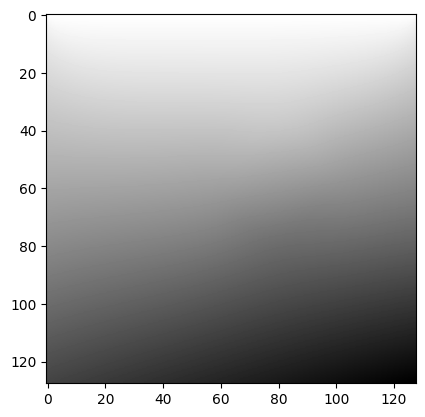

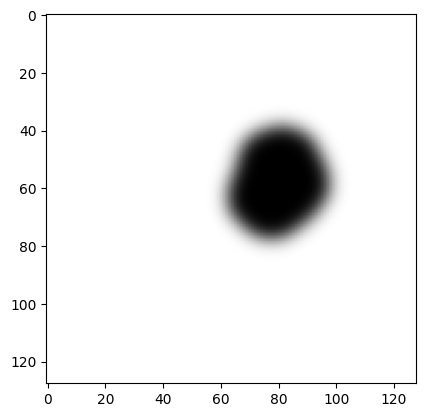

In [123]:
plt.figure()
plt.imshow(inp, cmap='gray')
plt.figure()
plt.imshow(re, cmap='gray')

In [124]:
len(val_dataset)

196

In [125]:
# val_dataset = val_dataset.batch(1)

In [126]:
len(val_dataset)

196

In [127]:
inp.shape

TensorShape([128, 128, 1])

### Generator Model

In [128]:
OUTPUT_CHANNELS = 1

In [129]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [130]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 64, 64, 3)


In [131]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [132]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [133]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    # down_stack = [
    #     downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    #     downsample(128, 3),  # (batch_size, 64, 64, 128)
    #     downsample(256, 3),  # (batch_size, 32, 32, 256)
    #     downsample(512, 3),  # (batch_size, 16, 16, 512)
    #     downsample(512, 3),  # (batch_size, 8, 8, 512)
    #     downsample(512, 3),  # (batch_size, 4, 4, 512)
    #     downsample(512, 3),  # (batch_size, 2, 2, 512)
    #     # downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # up_stack = [
    #     # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #     upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #     upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
    #     upsample(512, 3),  # (batch_size, 16, 16, 1024)
    #     upsample(256, 3),  # (batch_size, 32, 32, 512)
    #     upsample(128, 3),  # (batch_size, 64, 64, 256)
    #     upsample(64, 3),  # (batch_size, 128, 128, 128)
    # ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        # upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [134]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

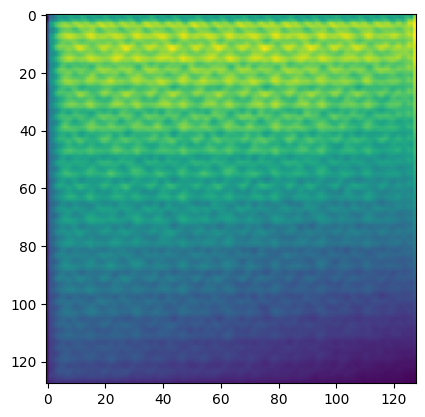

In [135]:
# Testing the generator
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [136]:
# gen_output[0]

In [137]:
gen_output.shape

TensorShape([1, 128, 128, 1])

In [138]:
with strategy.scope():
    generator = Generator()

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce te

In [139]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_tracker = tf.keras.metrics.MeanSquaredError(name='train_mse')
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name='val_mse')

In [140]:
with strategy.scope():
    loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    def generator_loss(gen_output, target):
        #Possible addition: regularizer
        # gan_loss = loss_object(gen_output, target)
        # return gan_loss
        per_example_loss = loss_object(gen_output, target)
        loss = tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
        return loss

In [141]:
with strategy.scope():
    # loss_tracker = tf.keras.metrics.Mean(name="train_loss")
    # val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
    # val_loss_mean = tf.keras.metrics.Mean(name='val_loss_mean')
    loss_tracker = tf.keras.metrics.MeanSquaredError(name='train_mse')
    val_loss_tracker = tf.keras.metrics.MeanSquaredError(name='val_mse')

In [142]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [143]:
generator_loss(gen_output, re[tf.newaxis,...])

<tf.Tensor: shape=(), dtype=float32, numpy=329.5042>

In [144]:
re[tf.newaxis,...].shape

TensorShape([1, 128, 128, 1])

In [145]:
gen_output.shape

TensorShape([1, 128, 128, 1])

### Optimizers and checkpoints

In [146]:
# generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [147]:
checkpoint_dir = f'{RESULTS_FOLDER}/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [148]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     generator=generator,
                                    )

In [149]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [150]:
def generate_images(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], tar[0], prediction[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted {mse_loss:.2f} {mape_loss:.2f}%']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png')
    plt.close()

In [151]:
plt.tight_layout()
def generate_images8(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    x = prediction.numpy()
    # if np.amax(x) > 1.0:
    #     x[x < 1.0] = 1.0
    # else:
    #     x[x > 1.0] = 1.0

    display_list = [test_input[0], tar[0], x[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='bwr')
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.1)
        plt.axis('on')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png', bbox_inches='tight')
    plt.close()

    # plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # plt.colorbar(location='bottom', pad=0.05)
    # plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

<Figure size 640x480 with 0 Axes>

In [152]:
for example_input, example_target in val_dataset.take(1):
    generate_images8(generator, example_input, example_target,6,6)

2023-08-11 16:17:25.812425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]


In [153]:
# for i, (example_input, example_target) in enumerate(val_dataset.take(1000)):
#     if i+1 == 49 or i+1 == 174:
#         generate_images8(generator, example_input, example_target,i+1,i+1)

### Training

In [154]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [155]:
log_dir=f"{RESULTS_FOLDER}/logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
gen_total_loss_list = []
gen_val_loss_list = []

In [156]:
# @tf.function
def train_step(inputs):
    input_image, target = inputs
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_total_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    loss_tracker.update_state(gen_output, target)
    return gen_total_loss

     # gen_total_loss_list.append(gen_total_loss.numpy())
    # print(f'Result:{loss_tracker.result()}')

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)

In [157]:
# @tf.function
def val_step(inputs):
    input_image, target = inputs
    gen_output = generator(input_image, training=False)
    # v_loss = loss_object(gen_output, target)
    # val_loss_mean.update_state(v_loss)
    val_loss_tracker.update_state(gen_output, target)
    
    # gen_val_loss = generator_loss(gen_output, target)
    # gen_val_loss_list.append(gen_val_loss)
    # val_loss_tracker.update_state(gen_val_loss)

    # print(gen_val_loss)

In [158]:
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [159]:
@tf.function
def distributed_val_step(dataset_inputs):
    return strategy.run(val_step, args=(dataset_inputs,))

In [160]:
min_val_loss = 100000;

In [161]:
epoch_wise_train_loss = []
epoch_wise_val_loss = []

In [162]:
# for x in train_dataset:
#     total_loss = distributed_train_step(x)
#     break

In [163]:
# total_loss

In [164]:
# for x in val_dataset:
#     total_loss = distributed_val_step(x)
#     break

In [165]:
# total_loss

In [166]:
# val_loss_mean.result()

In [167]:
def fit(train_ds, val_ds, epochs, steps=1):
    # example_input, example_target = next(iter(train_ds.take(1)))
    # example_input, example_target = inp, re
    start = time.time()
    min_val_loss = 1000
    
    for epoch in range(epochs):
        print("Iniside loop")
        total_loss = 0.0
        num_batches = 0
        for x in train_ds:
            total_loss += distributed_train_step(x)
            num_batches += 1
        train_loss = total_loss / num_batches
        print("training complete")
        for x in val_ds:
            distributed_val_step(x)
        print("val complete")
        if epoch % 10 == 0:
            checkpoint.save(checkpoint_prefix)
            generate_images(generator, inp[tf.newaxis,...], re[tf.newaxis,...], f'train/train-{epoch}', 10)
            with open(f'{RESULTS_FOLDER}/epoch.txt','a') as f:
                f.write(f"{epoch} epoch: took {time.time()-start:.2f} sec")
                f.write('\n')
                
        ## Save best model
        current_loss = val_loss_tracker.result().numpy()
        # current_loss = val_loss_mean.result().numpy()
        print("current loss",current_loss)
        print("Min vall loss",min_val_loss)
        if(current_loss < min_val_loss and epoch > 0):
            min_val_loss = current_loss
            generator.save_weights(BEST_PATH)
            print(f"Saving best weight with val loss:{min_val_loss} to {BEST_PATH}")

        epoch_wise_train_loss.append(loss_tracker.result().numpy())
        epoch_wise_val_loss.append(val_loss_tracker.result().numpy())
        
        loss_tracker.reset_states()
        val_loss_tracker.reset_states()
        # val_loss_mean.reset_states()
    
    generator.save_weights(MODEL_PATH)
    print(f'\nModel saved to: {MODEL_PATH}')
    print('min_val_loss',min_val_loss)
    with open(f'{RESULTS_FOLDER}/epoch.txt','a') as f:
        f.write(f"{epoch} epoch: took {time.time()-start:.2f} sec")
        f.write('\n')
        f.write(f'min_val_loss:{min_val_loss}')


        # if (epoch) % 10 == 0:
        #     # display.clear_output(wait=True)
        #     if epoch != 0:
        #         print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')
        #     start = time.time()
        #     generate_images(generator, example_input, example_target, f'train/train-{epoch}', step)
        #     print(f"Reached epoch: {epoch}")
        #     with open(f'{RESULTS_FOLDER}/epoch.txt','w') as f:
        #         f.write("\n")
        #         f.write(str(epoch))
        #     # generate_images(generator, exp_img, epoch, step)    

        # # Save (checkpoint) the model every 25 EPOCH
        # if (epoch)%25 == 0:
        #     print(f"Saving checkpoint at epoch:{epoch}")
        #     checkpoint.save(file_prefix=checkpoint_prefix)
        #     print(f"Step: {step}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        
        # print(f"Epoch: {epoch}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        # epoch_wise_train_loss.append(loss_tracker.result())
        # epoch_wise_val_loss.append(val_loss_tracker.result())
        # loss_tracker.reset_states()
        # val_loss_tracker.reset_states()
        # val_loss_mean.reset_states()
          
    # generator.save_weights(MODEL_PATH)
    # print(f'\nModel saved to: {MODEL_PATH}')
    # print('min_val_loss',min_val_loss)
    # with open(f'{RESULTS_FOLDER}/loss.txt','w') as f:
    #     f.write(str(min_val_loss))
    #     f.write("epoch")
    #     f.write(str(epoch))

In [168]:
# total_loss = 0.0
# num_batches = 0
# for x in train_dist_dataset:
#     total_loss += distributed_train_step(x)
#     num_batches += 1
#     break
#     # print(num_batches)

In [169]:
# total_loss

In [170]:
# for x in val_dist_dataset:
#     distributed_val_step(x)
#     break

In [171]:
# fit(train_dist_dataset,val_dist_dataset, epochs=EPOCHS)

In [172]:
# a = next(iter(strategy.experimental_distribute_dataset(train_dataset)))

In [173]:
# len(gen_total_loss_list)

In [174]:
# len(gen_val_loss_list)

In [175]:
# # plt.figure(figsize=(20, 15))
# plt.plot(gen_total_loss_list, label='train')
# plt.plot(gen_val_loss_list, label='val')
# plt.title("Training curve")
# plt.xlabel("Steps")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.savefig(f'{RESULTS_FOLDER}/train_val_curve.png')
# plt.show()


In [176]:
l1 = len(epoch_wise_train_loss)
l2 = len(epoch_wise_val_loss)
print(l1)
print(l2)
a = range(1,l1+1)
b = range(1,l2+1)

0
0


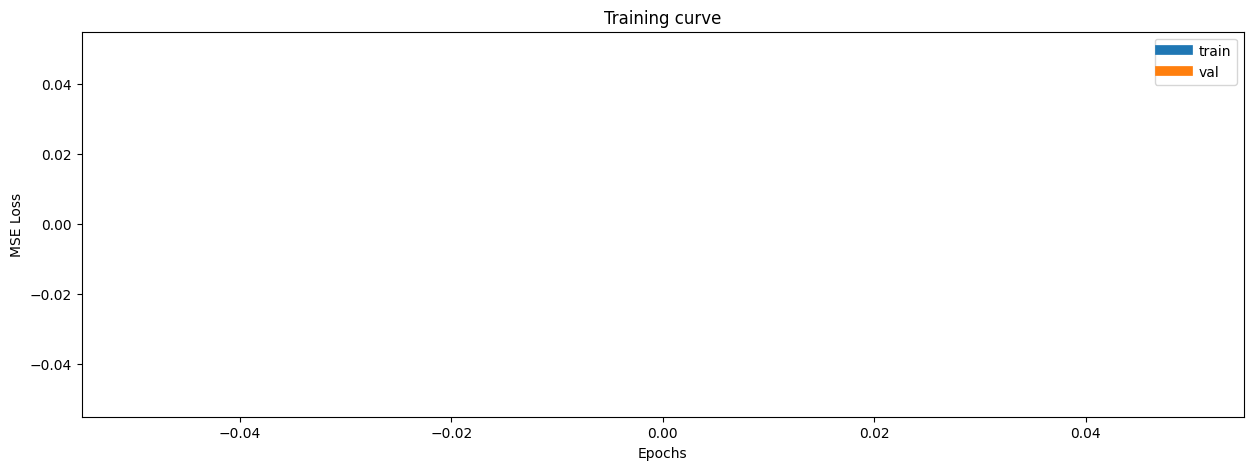

In [177]:
plt.figure(figsize=(15,5))
plt.plot(a, epoch_wise_train_loss, label='train', linewidth=7.0)
plt.plot(a, epoch_wise_val_loss, label='val', linewidth=7.0)
plt.title("Training curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
# plt.savefig(f'{RESULTS_FOLDER}/train_val_epoch_curve.png')
plt.show()

In [178]:
# with open(f"{}/epoch_wise_train_loss", "wb") as fp:   
#     pickle.dump(epoch_wise_train_loss, fp)
# with open("epoch_wise_val_loss", "wb") as fp:   
#     pickle.dump(epoch_wise_val_loss, fp)

In [179]:
# print(f'Train MSE at the end of training: {gen_total_loss_list[-1]}')
# print(f'Val MSE at the end of training: {gen_val_loss_list[-1]}')

### Testing

### Testing

In [180]:
generator.load_weights(BEST_PATH)

In [181]:
len(val_dataset)

196

In [182]:
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [183]:
len(val_dataset)

25000

In [184]:
from skimage import filters

In [185]:
def display_otsus(extracted_mod_img):
    numpy_data = extracted_mod_img[:,:,0].numpy()
    val = filters.threshold_otsu(numpy_data)
    thresholded_img = numpy_data > val
    return thresholded_img

In [186]:
def display_otsus2(extracted_mod_img):
    numpy_data = extracted_mod_img[:,:,0].numpy()
    val = filters.threshold_otsu(numpy_data)
    thresholded_img = numpy_data > val
    return thresholded_img,val

In [187]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [188]:
def avg_modulus(taget_or_pred, val):
    mod_at_each_point_soft = taget_or_pred[taget_or_pred < val]
    avg_mod_soft = tf.reduce_mean(mod_at_each_point_soft).numpy()
    mod_at_each_point_hard = taget_or_pred[taget_or_pred > val]
    avg_mod_hard = tf.reduce_mean(mod_at_each_point_hard).numpy()
    return avg_mod_soft, avg_mod_hard, mod_at_each_point_soft, mod_at_each_point_hard

In [189]:
def calculate_obj_mse(predicted_mod_img, thresholded_pred_mod, extracted_mod_img, thresholded_gt_mod):
    both_thresholded = np.logical_or(thresholded_pred_mod,thresholded_gt_mod)
    valued = predicted_mod_img.numpy().squeeze()
    numpy_data = extracted_mod_img.numpy().squeeze()
    assert both_thresholded.shape == valued.shape == numpy_data.shape
    ip = valued[both_thresholded]
    op = numpy_data[both_thresholded]
    mse_score_hard = np.mean(np.square(ip-op))
    
    ip = valued[np.logical_not(both_thresholded)]
    op = numpy_data[np.logical_not(both_thresholded)]
    mse_score_soft = np.mean(np.square(ip-op))
    return mse_score_hard, mse_score_soft

In [190]:
# with open(f'{RESULTS_FOLDER}/analysis.csv','w') as f:
#     f.write(f'index,mse,nmse,mape,dice, avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt, avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse\n')

In [191]:
avg_mse_loss_list = []
avg_mape_loss_list = []
list_dice_scores = []

In [192]:
i = 0
for test_image,test_target in val_dataset:
    
    test_prediction = generator(test_image,training=False)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    thresholded_pred_mod, value_pred = display_otsus2(test_prediction[0])
    thresholded_gt_mod, value_gt = display_otsus2(test_target[0])
    dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 
    list_dice_scores.append(dice_score)

    avg_mod_soft_pred, avg_mod_hard_pred, mod_aep_soft_pred, mod_aep_hard_pred = avg_modulus(test_prediction[0], value_pred)
    avg_mod_soft_gt, avg_mod_hard_gt, mod_aep_soft_gt, mod_aep_hard_gt = avg_modulus(test_target[0], value_gt)


    nmse_denominator = tf.math.reduce_mean(tf.keras.metrics.mean_squared_error(test_target, 0.0)).numpy()
    nmse = avg_mse_loss/nmse_denominator

    mod_err_hard = abs(avg_mod_hard_gt - avg_mod_hard_pred)
    rel_mod_err_hard = mod_err_hard/avg_mod_hard_gt

    mod_err_soft = abs(avg_mod_soft_gt - avg_mod_soft_pred)
    rel_mod_err_soft = mod_err_soft/avg_mod_soft_gt

    mse_score_hard, mse_score_soft = calculate_obj_mse(test_prediction[0], thresholded_pred_mod, test_target[0], thresholded_gt_mod)    
    
    
    i = i+1
    with open(f'{RESULTS_FOLDER}/analysis.csv','a') as f:
        f.write(f'{i},{avg_mse_loss},{nmse},{avg_mape_loss},{dice_score},{avg_mod_hard_gt},{avg_mod_hard_pred},{avg_mod_soft_gt},{avg_mod_soft_pred},{mod_err_hard},{rel_mod_err_hard},{mod_err_soft},{rel_mod_err_soft},{mse_score_hard},{mse_score_soft}\n')   

    # if i == 2:
    #     break

    # output = np.reshape(test_prediction, (128,128))
    # gt = np.reshape(test_target, (128,128))
    # i = i+1

    # file_name = f"{RESULTS_FOLDER}/raw_vals/{i}-pred.raw"
    # with open(file_name, 'wb') as fp:     
    #     output.tofile(fp)
    # fp.close()

    # file_name2 = f"{RESULTS_FOLDER}/raw_vals/{i}-gt.raw"
    # with open(file_name2, 'wb') as fp:     
    #     gt.tofile(fp)
    # fp.close()

2023-08-11 16:18:14.355782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]


In [193]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

0.00022623138334557552

In [194]:
len(avg_mape_loss_list)

25000

In [195]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

0.32348257682681086

In [196]:
len(list_dice_scores)

25000

In [197]:
final_dice = sum(list_dice_scores)/len(list_dice_scores)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal Dice:{final_dice}')
final_dice

0.8543818455800665

### Post - analysis

In [198]:
import pandas as pd

In [199]:
names = 'index,mse,nmse,mape,dice,avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt,avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse'

In [200]:
names = names.split(',')

In [201]:
df = pd.read_csv(f'{RESULTS_FOLDER}/analysis.csv',sep=",", header = 0, names=names)

In [202]:
df.head()

,index,mse,nmse,mape,dice,avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt,avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse
0,1,0.000005,0.000005,0.177115,0.999510,0.997567,0.998923,0.744511,0.746311,0.001356,0.001359,0.001800,0.002417,0.000004,0.000023
1,2,0.000059,0.000054,0.317940,0.994619,1.469937,1.490860,1.003120,1.005118,0.020924,0.014234,0.001998,0.001992,0.000637,0.000016
2,3,0.000591,0.000300,0.388214,0.997340,3.835108,3.855762,1.008709,1.009683,0.020655,0.005386,0.000974,0.000966,0.006258,0.000170
3,4,0.000059,0.000034,0.246662,0.995486,3.205012,3.214258,1.022685,1.024147,0.009246,0.002885,0.001462,0.001430,0.000555,0.000019
4,5,0.000132,0.000063,0.303686,0.998549,3.652843,3.667607,1.019109,1.020727,0.014764,0.004042,0.001617,0.001587,0.001135,0.000040


In [203]:
df.shape

(25000, 15)

In [204]:
inclusion = []
for a_log_path in log_val_path:
    with open(a_log_path) as f:
        data = f.read()
    data = data.split(' ')
    mod = data[9]
    assert mod == 'mod1'
    foreground = float(data[10].splitlines()[0])
    if foreground < 1.0:
        inclusion.append('soft')
    elif foreground > 1.0:
        inclusion.append('hard')
    else:
        print('error')

In [205]:
len(inclusion)

3000

In [206]:
s1 = inclusion[0:1000]
s2 = inclusion[1000:2000]
s2_updated = list(np.repeat(s2,8))
s3 = inclusion[2000:3000]
s3_updated = list(np.repeat(s3,16))
inclusion = s1 + s2_updated + s3_updated

In [207]:
len(inclusion)

25000

In [208]:
df['inclusion'] = inclusion

In [209]:
df['inclusion']

0        soft
1        hard
2        hard
3        hard
4        hard
         ... 
24995    hard
24996    hard
24997    hard
24998    hard
24999    hard
Name: inclusion, Length: 25000, dtype: object

In [210]:
df.head(6)

,index,mse,nmse,mape,dice,avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt,avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse,inclusion
0,1,0.000005,0.000005,0.177115,0.999510,0.997567,0.998923,0.744511,0.746311,0.001356,0.001359,0.001800,0.002417,0.000004,0.000023,soft
1,2,0.000059,0.000054,0.317940,0.994619,1.469937,1.490860,1.003120,1.005118,0.020924,0.014234,0.001998,0.001992,0.000637,0.000016,hard
2,3,0.000591,0.000300,0.388214,0.997340,3.835108,3.855762,1.008709,1.009683,0.020655,0.005386,0.000974,0.000966,0.006258,0.000170,hard
3,4,0.000059,0.000034,0.246662,0.995486,3.205012,3.214258,1.022685,1.024147,0.009246,0.002885,0.001462,0.001430,0.000555,0.000019,hard
4,5,0.000132,0.000063,0.303686,0.998549,3.652843,3.667607,1.019109,1.020727,0.014764,0.004042,0.001617,0.001587,0.001135,0.000040,hard
5,6,0.000385,0.000428,1.922595,0.998440,0.997148,0.999696,0.120360,0.146425,0.002548,0.002555,0.026065,0.216556,0.000363,0.000583,soft


In [211]:
df_soft = df[df['inclusion']=='soft']

In [212]:
df_hard = df[df['inclusion']=='hard']

In [213]:
df_hard['mape'] = df_hard['mape']
df_soft['mape'] = df_soft['mape']

In [214]:
df_soft.shape

(12735, 16)

In [215]:
df_hard.shape

(12265, 16)

In [216]:
# df

In [217]:
# df_soft

In [218]:
# df_hard

In [219]:
df_hard = df_hard.drop(columns=['inclusion'])

In [220]:
df_hard.mean()

index                12589.233102
mse                      0.000413
nmse                     0.000222
mape                     0.292849
dice                     0.852085
avg_mod_hard_gt          2.734836
avg_mod_hard_pred        2.502704
avg_mod_soft_gt          1.010533
avg_mod_soft_pred        1.010535
mod_err_hard             0.037478
rel_mod_err_hard         0.013441
mod_err_soft             0.001489
rel_mod_err_soft         0.001477
hard_obj_mse             0.009138
soft_obj_mse             0.000074
dtype: float64

In [221]:
df_hard.max()

index                25000.000000
mse                      0.012205
nmse                     0.005500
mape                     1.189531
dice                     1.000000
avg_mod_hard_gt          4.901711
avg_mod_hard_pred        4.855330
avg_mod_soft_gt          1.068278
avg_mod_soft_pred        1.069587
mod_err_hard             2.200212
rel_mod_err_hard         0.650569
mod_err_soft             0.026864
rel_mod_err_soft         0.026862
hard_obj_mse             2.295625
soft_obj_mse             0.002005
dtype: float64

In [222]:
# df_hard.std()

In [223]:
df_soft = df_soft.drop(columns=['inclusion'])

In [224]:
df_soft.mean()

index                12415.041696
mse                      0.000046
nmse                     0.000049
mape                     0.352986
dice                     0.856594
avg_mod_hard_gt          0.997342
avg_mod_hard_pred        0.999293
avg_mod_soft_gt          0.573110
avg_mod_soft_pred        0.634598
mod_err_hard             0.001479
rel_mod_err_hard         0.001483
mod_err_soft             0.009820
rel_mod_err_soft         0.024891
hard_obj_mse             0.000034
soft_obj_mse             0.000755
dtype: float64

In [225]:
# df_soft.std()

In [226]:
df_soft.min()

index                1.000000e+00
mse                  2.414387e-06
nmse                 2.414386e-06
mape                 1.284138e-01
dice                 0.000000e+00
avg_mod_hard_gt      9.845751e-01
avg_mod_hard_pred    9.860791e-01
avg_mod_soft_gt      1.042571e-01
avg_mod_soft_pred    1.358417e-01
mod_err_hard         1.251698e-06
rel_mod_err_hard     1.255434e-06
mod_err_soft         7.748604e-07
rel_mod_err_soft     1.513742e-06
hard_obj_mse         2.404527e-06
soft_obj_mse         2.164243e-07
dtype: float64

In [227]:
### EOF - Analysis

In [139]:
generator.load_weights(BEST_PATH)

In [140]:
len(val_dataset)

36

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [122]:
avg_mse_loss_list = []
avg_mape_loss_list = []

i = 0
for test_image,test_target in val_dataset:
    test_prediction = generator(test_image,training=False)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    output = np.reshape(test_prediction, (128,128))
    gt = np.reshape(test_target, (128,128))
    i = i+1

    file_name = f"{RESULTS_FOLDER}/raw_vals/{i}-pred.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    file_name2 = f"{RESULTS_FOLDER}/raw_vals/{i}-gt.raw"
    with open(file_name2, 'wb') as fp:     
        gt.tofile(fp)
    fp.close()

In [123]:
len(avg_mse_loss_list)

In [124]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

In [125]:
len(avg_mape_loss_list)

In [126]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

In [128]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images(generator, test_image, test_target,'val/valfull-',i)

2023-07-31 14:46:02.935510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [9000]
	 [[{{node Placeholder/_1}}]]
2023-07-31 14:46:07.195764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-31 14:46:12.033163: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2023-07-31 14:46:12.074995: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [129]:
# generator.load_weights(BEST_PATH)

In [ ]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images8(generator, test_image, test_target,'val_c/valfull_c-',i)

In [ ]:
# Generate plots for test set
# for i, (test_input, test_target) in val_dataset.take(500).enumerate():
#     generate_images(generator, test_input, test_target,'test',i)

In [50]:
len(val_dataset)

9000

In [ ]:
## Calculate modulus

In [ ]:
# all_raw_data_path = 'raw_exps/*.raw'
# all_raw_data = glob.glob(all_raw_data_path)

In [ ]:
# all_raw_data.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
# all_raw_data

In [ ]:
# threshold = 0.45

In [ ]:
# all_modulus = []

In [ ]:
# for a_data in all_raw_data:
#     img = np.fromfile(a_data,dtype = 'float32', sep="")
#     name = a_data.split('/')[-1].split('.')[0]
#     modulus = img[img<threshold]
#     if len(modulus) != 0:
#         avg_modulus = sum(modulus)/len(modulus)
    
#     all_modulus.append((name,avg_modulus))

#     with open('modulus_values.txt', 'a') as f:
#         f.write(f"{name},{avg_modulus}\n")
    
    

In [ ]:
# for i in all_modulus:
#     print(i)